### Load Packages

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
#%matplotlib notebook
from IPython import display
import pandas as pd

import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K
import os
import cv2
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

Fixing parameters 

In [3]:
NB_POSTURE = 50
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 128
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


Creation of the training data: 
- train_posture_before : joint angles before command
- train_posture_after  : joint angles after command is applied
- command : command applied
- train_position_before : end effector position before command
- train_position_after : end effector position after command is applied.

In [4]:
train_posture_before, train_posture_after, train_command, train_position_before, train_position_after  = create_random_data(NB_POSTURE, NB_COMMAND, "train")
train_images = load_and_process_images(NB_DATA, "train")
#test_posture_before, test_posture_after, test_command, test_position_before, test_position_after = create_random_data(10,10, "test")
#test_images = load_and_process_images(100, "test")

100%|██████████| 5000/5000 [00:21<00:00, 234.03it/s]


Saving the training data

In [5]:
train_images_pickle = open("pickles/train_images.pickle", "wb")
train_command_pickle = open("pickles/train_command.pickle", "wb")
train_posture_before_pickle = open("pickles/train_posture_before.pickle", "wb")
train_posture_after_pickle = open("pickles/train_posture_after.pickle", "wb")
train_position_before_pickle = open("pickles/train_position_before.pickle", "wb")
train_position_after_pickle = open("pickles/train_position_after.pickle", "wb")

pickle.dump(train_images, train_images_pickle)
pickle.dump(train_command, train_command_pickle)
pickle.dump(train_posture_before, train_posture_before_pickle)
pickle.dump(train_posture_after, train_posture_after_pickle)
pickle.dump(train_position_before, train_position_before_pickle)
pickle.dump(train_position_after, train_position_after_pickle)

train_images_pickle.close()
train_command_pickle.close()
train_posture_before_pickle.close()
train_posture_after_pickle.close()
train_position_after_pickle.close()
train_position_before_pickle.close()

Loading saved data (_not useful in general_)

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "rb")
train_command_pickle = open("pickles/train_command.pickle", "rb")
train_posture_before_pickle = open("pickles/train_posture_before.pickle", "rb")
train_posture_after_pickle = open("pickles/train_posture_after.pickle", "rb")
train_position_before_pickle = open("pickles/train_position_before.pickle","rb")
train_position_after_pickle = open("pickles/train_position_after.pickle", "rb")



train_command = pickle.load(train_command_pickle)
train_images = pickle.load(train_images_pickle)
train_posture_before = pickle.load(train_posture_before_pickle)
train_posture_after = pickle.load(train_posture_after_pickle)
train_position_before = pickle.load(train_position_before_pickle)
train_position_after = pickle.load(train_position_after_pickle)

train_images_pickle.close()
train_command_pickle.close()
train_posture_after_pickle.close()
train_posture_before_pickle.close()
train_position_before_pickle.close()
train_position_after_pickle.close()

Creation of the tf.dataset

In [6]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

visu_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,]))
    .repeat(10)
    .shuffle(NB_DATA)
)

### Main convolutional model

Creation, compilation and training of the model.

In [7]:
encoder_conv = build_conv2D_pointwise_encoder()
decoder_dense = build_dense_pointwise_decoder()

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input,
                                  decoder_dense(encoder_conv(encoder_conv.input)),
                                  name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
                         loss='mse',
                         metrics=['accuracy','kullback_leibler_divergence'])

In [10]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 8)#, 
                    #steps_per_epoch = 50)
                    #callbacks=[tensorboard_callback])

Epoch 1/8
500/500 [==============================] - 127s 253ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0312
Epoch 2/8
500/500 [==============================] - 123s 246ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0492
Epoch 3/8
500/500 [==============================] - 123s 246ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0532
Epoch 4/8
401/500 [=======================>......] - ETA: 24s - loss: 0.0013 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0545

KeyboardInterrupt: 

Plot the loss function

In [ ]:
encoder_conv.load_weights('models/encoder_conv.h5')
decoder_dense.load_weights('models/decoder_dense.h5')

autoencoder_conv = tf.keras.Model(encoder_conv.input,
                                  decoder_dense(encoder_conv(encoder_conv.input)),
                                  name = "autoencoder")

In [ ]:
encoder_conv.save("models/encoder_conv.h5")
decoder_dense.save("models/decoder_dense.h5")

Example of reconstructed image

In [11]:
example_data = next(iter(train_dataset))


In [12]:
res = encoder_conv.predict(example_data)

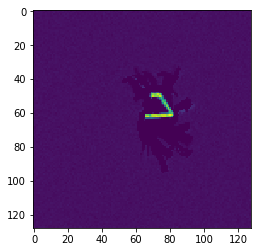

In [13]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

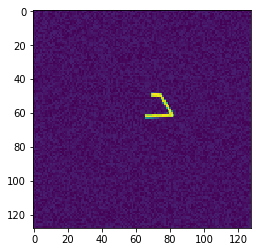

In [14]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

### Visualization of dense layers

### t-SNE 

### 3D t-SNE animation

## Control model

In [15]:
control_model = build_control_model()

In [16]:
def prepare_dataset(train_command, train_posture_before, train_posture_after, train_position_after, train_position_before):

    t_before = map(lambda x : x[0,:], train_posture_before)
    t_before = np.expand_dims(t_before, 1)
    
    t_after = map(lambda x : x[0,:], train_posture_after)
    t_after = np.expand_dims(t_after, 1)
    
    t_command = map(lambda x : x[0,:], train_command)
    t_command = np.expand_dims(t_command, 1)

    t_visual_direction = normalize_vect(train_position_after - train_position_before)
    t_visual_direction = padding(t_visual_direction, 2)

    orientation_before = np.array(map(lambda x : get_end_effector_orientation(x), t_before[:,0,:]))
    orientation_after = np.array(map(lambda x : get_end_effector_orientation(x), t_after[:,0,:]))
    
    t_orientation = orientation_after - orientation_before
    t_orientation =  np.expand_dims(t_orientation, 1)
    t_orientation = padding(t_orientation, 3)
    
    tmp_input = np.concatenate([t_orientation, t_before], axis = 1)

    train_control_dataset = (
        tf.data.Dataset.from_tensor_slices((tmp_input, t_command))
        .repeat(10)
        .shuffle(NB_DATA)
        .batch(BATCH_SIZE)
        )

    return train_control_dataset


In [17]:
optimizer = tf.keras.optimizers.Adam(1e-3)

control_model.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [18]:
train_control_dataset = prepare_dataset(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)

In [19]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = control_model.fit(train_control_dataset, 
                    epochs = 10)

Epoch 1/10
500/500 [==============================] - 3s 5ms/step - loss: 0.0021 - accuracy: 0.4491 - kullback_leibler_divergence: 0.5866
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4555 - kullback_leibler_divergence: 0.5777
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4566 - kullback_leibler_divergence: 0.5779
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4567 - kullback_leibler_divergence: 0.5787
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4570 - kullback_leibler_divergence: 0.5792
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4573 - kullback_leibler_divergence: 0.5801
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.4571 - kullback_leibler_divergence: 0.5807
Epoch 8/10
500/500 [==============

In [20]:
control_model.save('models/control_model.h5')

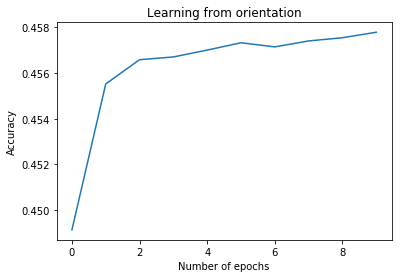

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.title("Learning from orientation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()

#### Example


In [22]:
example_data = next(iter(train_control_dataset))
res = control_model.predict(example_data)
shape(example_data)
mean(res - example_data[1])

-0.0003971475264744163

In [23]:
current_posture = np.array([[0.3,0.3,0.2, 0.2, 0.1]])
visual_direction = np.array([1,0,0])

postures = test_visuomotor_control(control_model, current_posture, visual_direction)
t = compute_trajectory(postures)


<IPython.core.display.Javascript object>


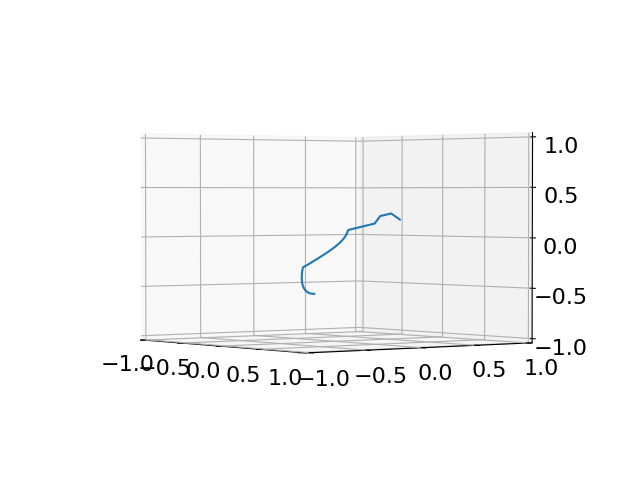

In [24]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])

In [37]:
def compute_trajectory(postures):
    tmp = []
    #print shape(postures)
    for i in range(len(postures)):
        tmp.append(control_robot(postures[i][0]))
    return np.array(tmp)




In [25]:
def go_to_position(control_model, current_posture, target_position, nb_pass = 500):
    postures = []
    vd = []


    visual_direction = compute_vd_from_position(target_position, current_posture)

    postures.append(current_posture)
    vd.append((visual_direction))
    j = 0
    while (j < nb_pass) and (np.linalg.norm(target_position - np.array(control_robot(current_posture[0]))) > 0.1):


        inputs = np.expand_dims(np.concatenate([visual_direction, current_posture], axis=0), 0)

        new_command = control_model.predict(inputs)

        #new_command = command_bornee(new_command)
        current_posture = current_posture + new_command[0]
        current_posture = check_valid_posture(current_posture)

        visual_direction = compute_vd_from_position(target_position, current_posture)

        postures.append(current_posture)
        vd.append((visual_direction))
        visual_direction = compute_vd_from_position(target_position, current_posture)/np.linalg.norm(visual_direction)
        j +=1

    return postures, np.array(vd)


In [26]:
target_position = [[0.2,0.24,-0.2]]
postures, vd = go_to_position(control_model, current_posture, target_position)
t = compute_trajectory(postures)


<IPython.core.display.Javascript object>


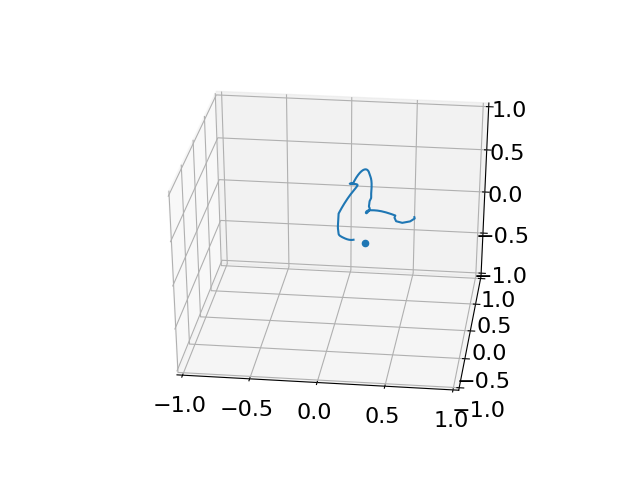

In [27]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])
ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2])


#### Error between asked and executed constant visual direction mvmt 

### Control model with orientation 

In [28]:
def get_end_effector_orientation(angles):
    """function calculating end effector postion from joint angles

    Args :
        phi1, phi2, theta1, theta2 : joint angles (4 dof arm )

    Returns:
        x,y,z : end effector position
        vx,vy,vz : speed i guess...
    """
    phi1, phi2, theta1,psi1, psi2 = angles
 
    
    return np.array([psi1+phi2+theta1, phi1])


def prepare_dataset_with_orientation(train_command, train_posture_before, train_posture_after, train_position_after, train_position_before):

    t_before = map(lambda x : x[0,:], train_posture_before)
    t_before = np.expand_dims(t_before, 1)
    
    
    t_after = map(lambda x : x[0,:], train_posture_after)
    t_after = np.expand_dims(t_after, 1)
    
    t_command = map(lambda x : x[0,:], train_command)
    t_command = np.expand_dims(t_command, 1)
    
    
    orientation_before = np.array(map(lambda x : get_end_effector_orientation(x), t_before[:,0,:]))
    orientation_after = np.array(map(lambda x : get_end_effector_orientation(x), t_after[:,0,:]))
    
    t_orientation = orientation_after - orientation_before
    t_orientation = np.expand_dims(t_orientation, 1)

    
    t_visual_direction = normalize_vect(train_position_after - train_position_before)
    #t_visual_direction = padding(t_visual_direction, 2)

    info = np.concatenate((t_visual_direction, t_orientation), axis=2)
    
    tmp_input = np.concatenate([info, t_before], axis = 1)
    
    train_control_dataset = (
        tf.data.Dataset.from_tensor_slices((tmp_input, t_command))
        .repeat(10)
        .shuffle(NB_DATA)
        .batch(100)
        )

    return train_control_dataset

def build_control_orientation_model():
    """ visual_direction and posture before as input
        motor command as output
    """
    LATENT_DIM = 32
    inputs = tf.keras.layers.Input(shape=(2,5))

    h = tf.keras.layers.Lambda(lambda x: x[:,0,:])(inputs)
    p = tf.keras.layers.Lambda(lambda x: x[:,1,:])(inputs)

    h = tf.keras.layers.Reshape((1,5))(h)
    p = tf.keras.layers.Reshape((1,5))(p)

    fh = tf.keras.layers.Flatten()(h)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_1')(fh)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_2')(fh)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_3')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_4')(fh)
    fh = tf.keras.layers.Reshape((LATENT_DIM, 1))(fh)

    fp = tf.keras.layers.Flatten()(p)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_1')(fp)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_2')(fp)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_3')(fp)
    #fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_4')(fp)
    fp = tf.keras.layers.Reshape((LATENT_DIM,1))(fp)

    matmul = tf.keras.layers.Multiply()([fp, fh])

    fy = tf.keras.layers.Flatten()(matmul)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_2')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_3')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_4')(fy)
    fy = tf.keras.layers.Dense(5, name = 'latent_y_out')(fy)
    fy = tf.keras.layers.Reshape((1,5))(fy)

    outputs = fy

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name='control_model')

    return model

In [29]:
control_model_with_orientation = build_control_orientation_model()
optimizer = tf.keras.optimizers.Adam(1e-3)

control_model_with_orientation.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])
train_control_orientation_dataset = prepare_dataset_with_orientation(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = control_model_with_orientation.fit(train_control_orientation_dataset, 
                    epochs = 10)


Epoch 1/10
500/500 [==============================] - 2s 5ms/step - loss: 0.0016 - accuracy: 0.5492 - kullback_leibler_divergence: 0.3362
Epoch 2/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5870 - kullback_leibler_divergence: 0.2714
Epoch 3/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5887 - kullback_leibler_divergence: 0.2699
Epoch 4/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5895 - kullback_leibler_divergence: 0.2693
Epoch 5/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5903 - kullback_leibler_divergence: 0.2693
Epoch 6/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5912 - kullback_leibler_divergence: 0.2691
Epoch 7/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.5911 - kullback_leibler_divergence: 0.2689
Epoch 8/10
500/500 [==============

<IPython.core.display.Javascript object>


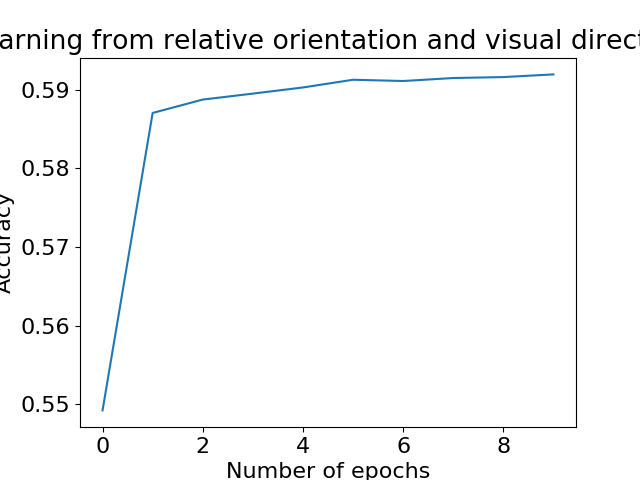

In [30]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.title('Learning from relative orientation and visual direction')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [194]:
control_model_with_orientation.save("models/control_model_with_orientation.h5")

In [118]:
def compute_vd_from_position_with_orientation(target_position, current_posture):

    current_position = control_robot(current_posture[0])
    #current_position  = np.expand_dims(current_position, 0)
    tmp = (np.array(target_position)-np.array(current_position))
    return np.expand_dims(tmp[0], 0)

def compute_orientation_from_vd(visu):
    x, y, z = visu[0]
    rho = np.sqrt(x*x+y*y+z*z)
    theta = np.arccos(z/rho)
    phi = np.arctan(y/x)

    return np.array([[phi, theta]])

def go_to_position_and_orientation(control_model, current_posture, target_position, target_orientation = np.array([[0,0]]), nb_pass = 500):
    postures = []
    
    visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)
    
    #target_orientation = compute_orientation_from_vd(visual_direction)
    postures.append(current_posture)

    j = 0
    while (j < nb_pass) and (np.linalg.norm(target_position - np.array(control_robot(current_posture[0]))) > 0.05):
        
        
        info = np.concatenate((visual_direction, target_orientation), axis= 1)
        
        inputs = np.expand_dims(np.concatenate([info, current_posture], axis=0), 0)

        new_command = control_model.predict(inputs)

        new_command = command_bornee(new_command, 0.1)
        current_posture = current_posture + new_command[0]
        current_posture = check_valid_posture(current_posture)

        visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)
        #target_orientation = compute_orientation_from_vd(visual_direction)
    
        postures.append(current_posture)

        visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)/np.linalg.norm(visual_direction)
        j +=1

    return postures
def command_bornee(command, borne = 0.5):
    new_command = np.zeros(shape(command))
    
    for i in range(5):
        if abs(command[0][0][i]) > (borne):
            new_command[0][0][i] = np.sign(command[0][0][i])*borne
        else :
            new_command[0][0][i] = command[0][0][i]
        
    return new_command


In [119]:
target_orientation = np.array([[0,0]])

def control_robot(angles):
    """function calculating end effector postion from joint angles

    Args :
        phi1, phi2, theta1, theta2 : joint angles (4 dof arm )

    Returns:
        x,y,z : end effector position
        vx,vy,vz : speed i guess...
    """
    phi1, phi2, theta1, psi1, psi2 = angles
    x = L1*cos(phi1)*cos(phi2)+L2*cos(phi1)*cos(phi2+theta1)+ L3*cos(phi2+theta1+psi1)*cos(phi1)
    y =  L1*sin(phi1)*cos(phi2)+L2*sin(phi1)*cos(phi2+theta1) + L3*cos(psi1+phi2+theta1)*sin(phi1) # ELBOW + HAND
    z =L1 * sin(phi2) + L2 * sin(phi2 +theta1) + L3*sin(psi1+phi2+theta1)  # ELBOW + HAND

    return np.array([x, y,z])


<IPython.core.display.Javascript object>


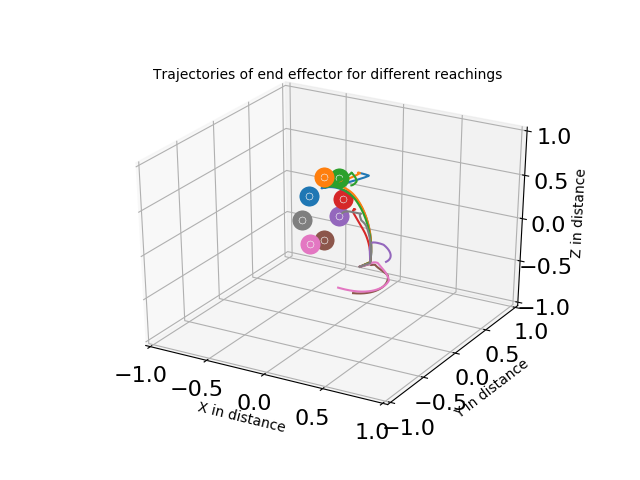

Text(0.5,0,'Z in distance')

In [127]:
current_posture = train_posture_before[0]
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
i = -1
j = 1.1
b = 0.1
c = -0.2
D = 0.1
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
targets = np.array([
    [[0.2*i+b,0*j+c,0.4*j+D]], 
    [[0.2*i+b,0.2*j+c,0.5*j+D]], 
    [[0.2*i+b,0.4*j+c,0.4*j+D]],
    [[0.2*i+b,0.45*j+c,0.15*j+D]], 
    [[0.2*i+b,0.4*j+c,0*j+D]], 
    [[0.2*i+b,0.2*j+c, -0.15*j+D]], 
    [[0.2*i+b,-0*j+c, -0.1*j+D]], 
    [[0.2*i+b,-0.1*j+c,0.2*j+D]]
    
])
for i in range(len(targets)):
    target_position = targets[i]
    
    posture = go_to_position_and_orientation(
        control_model_with_orientation,
        current_posture,
        target_position,
        target_orientation)
    
    t = compute_trajectory(posture)
    ax.plot(t[:,0], t[:,1], t[:,2])
    ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2], linewidths = 10)
ax.set_title("Trajectories of end effector for different reachings", fontsize = 10)
ax.set_xlabel("X in distance", fontsize = 10)
ax.set_ylabel("Y in distance", fontsize = 10)
ax.set_zlabel("Z in distance", fontsize = 10)

<IPython.core.display.Javascript object>


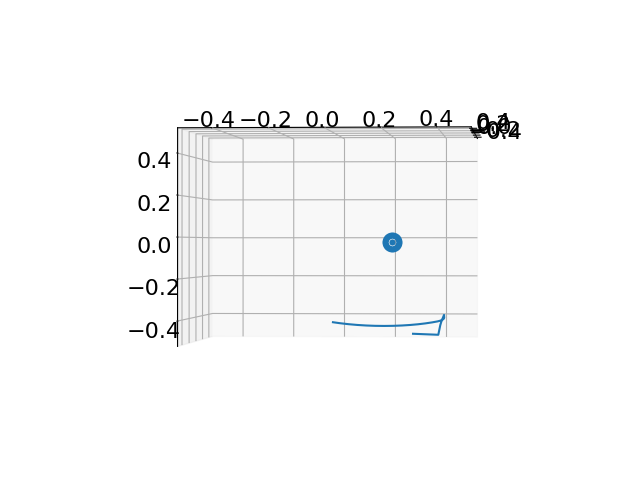

[ 0.12052907  0.31542973 -0.02283407] [array([ 0.02052907,  0.21542973, -0.02283407])]


In [129]:
fig = plt.figure()
current_posture = train_posture_before[0]
current_position = control_robot(current_posture[0])

target_position = [current_position + [-0.1,-0.1, -0.]]
print current_position, target_position
ax = plt.axes(projection='3d')
#target_position = [[0.4,0.5,0.2]]
posture = go_to_position_and_orientation(control_model_with_orientation, current_posture, target_position, target_orientation)
t = compute_trajectory(posture)
ax.plot(t[:,0], t[:,1], t[:,2])
ax.set_xlim(left=-0.5, right=0.5)
ax.set_ylim(bottom=-0.5, top=0.5)
ax.set_zlim(bottom=-0.5, top=0.5)
ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2], linewidths = 10)
plt.show()

<IPython.core.display.Javascript object>


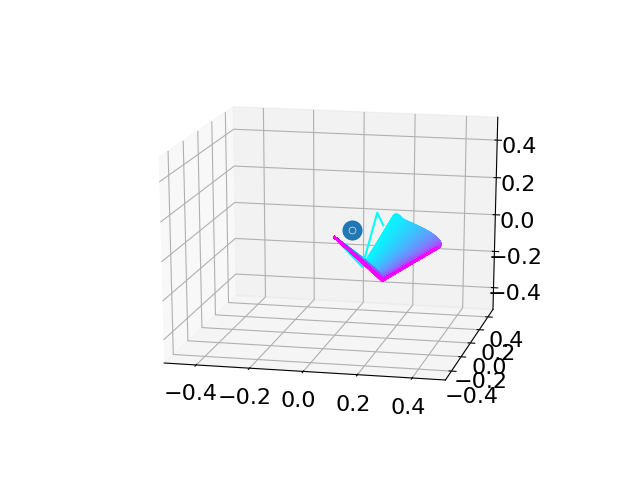

In [130]:
from __future__ import division
fig = plt.figure()

ax = plt.axes(projection='3d')

x = np.linspace(0, 3, 100)
k = 2*np.pi
w = 2*np.pi
dt = 0.01  

t = 0
cmap = cm.cool
L3 = 0.09
ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2], linewidths = 10)
ax.set_xlim(left=-0.5, right=0.5)
ax.set_ylim(bottom=-0.5, top=0.5)
ax.set_zlim(bottom=-0.5, top=0.5)
for i in range(0, (len(posture))):
    phi1, phi2, theta1, psi1, psi2 = posture[i][0]
    x = [0, 0, L1 * cos(phi1) * cos(phi2),
         L1*cos(phi1)*cos(phi2)+L2*cos(phi1)*cos(phi2+theta1),
         L1*cos(phi1)*cos(phi2)+L2*cos(phi1)*cos(phi2+theta1)+ L3*cos(phi2+theta1+psi1)*cos(phi1)]
    y = [0, 0, L1 * sin(phi1) * cos(phi2),
         L1*sin(phi1)*cos(phi2)+L2*sin(phi1)*cos(phi2+theta1),
         L1*sin(phi1)*cos(phi2)+L2*sin(phi1)*cos(phi2+theta1) + L3*cos(psi1+phi2+theta1)*sin(phi1)]
    z = [0, 0, L1 * sin(phi2),
         L1 * sin(phi2) + L2 * sin(phi2+theta1)  ,
         L1 * sin(phi2) + L2 * sin(phi2 +theta1) + L3*sin(psi1+phi2+theta1)]


    r = 1/len(posture)
    
    plt.plot(x, y, z, color = cmap(i*r))
    plt.pause(0.01) # pause avec duree en secondes
    t = t + dt

plt.show()

### Confusion matrix

In [111]:
from sklearn.metrics import classification_report, confusion_matrix

In [141]:
example_data = next(iter(train_control_orientation_dataset))
res = control_model.predict(example_data)
print shape(res)
y_true = np.array(example_data[1])
y_pred = np.array(res)
clas =  (y_true - y_pred) < 0.01

(100, 1, 5)


#### Visual analysis of control model filters

### 3d visualization of neural activity

In [ ]:
%matplotlib notebook
def select_random_posture():
    posture = zeros((nb_posture, 5))
    posture[:, 0] = randrange(nb_posture, -pi/2, pi/2)
    posture[:, 1] = randrange(nb_posture, -pi/2,  pi/2)
    posture[:, 2] = randrange(nb_posture, 0,  pi/2)
    posture[:, 3] = randrange(nb_posture, -pi, pi)
    posture[:, 4] = randrange(nb_posture, -pi/2,  pi/2)
    return posture

def select_lin_posture(n):
    position = zeros((10*n*n, 4))
    phi1 = linspace(0,2*pi/3,n)
    phi2 = linspace(0,2*pi/3,n)
    theta1 = linspace(0,2*pi/3,n)
    xx, yy, zz = meshgrid(phi1, phi2, theta1)
    position[:,0] = xx.flatten()
    position[:,1] = yy.flatten()
    position[:,2] = zz.flatten()
    
    return position 

def select_lin_command(n):
    commands = zeros((10*n*n, 4))
    c0 = linspace(-1,1,n)*0.2
    c1 = linspace(-1,1,n)*0.2
    c2 = linspace(-1,1,n)*0.2
    cc0, cc1, cc2 = meshgrid(c0,c1,c2)
    commands[:,0] = cc0.flatten()
    commands[:,1] = cc1.flatten()
    commands[:,2] = cc2.flatten()
    
    return commands
    
def select_command():
    command = zeros(4)
    command[0] = randrange(1,-1, 1) * 0.25
    command[1] = randrange(1,-1, 1) * 0.25
    command[2] = random.choice(
        [-1, 1]) * np.sqrt(0.375 - (command[0] * command[0] + command[1] * command[1]))
    return command

def create_image_visu(posture, i):
    phi1, phi2, theta1 = posture[0], posture[1], posture[2]
    name = "visualization/%s" %i
    plot_arm(phi1, phi2, theta1, name)
    
def compute_random_activity_for_position(model, i):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for k in (range(300)):
        posture_before = select_random_posture()
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            command = select_command()
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.Greens((moy) *2))
        
    plt.show()

def compute_activity_for_position(model, i):
    """ compute averaged-command initial-position specific neural activity
    
    Args : 
        model : a keras model object
        i : neuron index
    
    Returns : 
        null
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    postures = select_lin_posture(10)
    command = select_command()
    for k in (range(100)):
        
        posture_before = postures[k]
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.seismic((moy)))
        
    plt.show()
   

In [21]:
%matplotlib inline
def compute_loss_vd(model, pos_init, joint_command, filter_index):
    img = generate_input_from_vd(pos_init,  joint_command)
    output = model.predict(img)
    
    loss = output[0][0][filter_index]
    
    return loss

#@tf.function
def generate_img_from_pos(angles):
    
    phi1, phi2, theta1, psi1, psi2 = angles
    x = [0, 0, L1 * cos(phi1) * cos(phi2),
         (L1*cos(phi1)+L2*cos(theta1+phi1))*cos(phi2),
         (L1*cos(phi1)+L2*cos(theta1+phi1))*cos(phi2)+ L3*cos(psi1)*cos(psi2)]
    y = [0, 0, L1 * sin(phi1) * cos(phi2),
         (L1*cos(phi1)+L2*cos(theta1+phi1))*sin(phi2),
         (L1*cos(phi1)+L2*cos(theta1+phi1))*sin(phi2) + L3*cos(psi1)*sin(psi2)]
    z = [0, 0, L1 * sin(phi2),
         L1 * sin(phi1) + L2 * sin(theta1 + phi1)  ,
         L1 * sin(phi1) + L2 * sin(theta1 + phi1) + L3*sin(psi1)]

    # Hide grid lines
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    ax.grid(False)
    ax.set_facecolor((0.0, 0.0, 0.0))

    ax.set_xlim(left=-0.5, right=0.5)
    ax.set_ylim(bottom=-0.5, top=0.5)
    ax.set_zlim(bottom=-0.5, top=0.5)
    ax.axis('off')
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    fig.canvas.draw()
    
    x = np.array(fig.canvas.renderer.buffer_rgba())
    x = np.reshape(x, (288,432,4))
    
    tmp = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    tens_shape = shape(tmp)
    t = tf.convert_to_tensor(np.random.random(
        tens_shape), dtype='float32') * 0.1

    
    #tmp = tf.reshape(tmp, [1,64,64,4])
    
    plt.close()
    
    return tf.add(tmp, t)/255.0


def generate_input_from_vd(pos_before, joint_command):

    pos_before = tf.reshape(pos_before, [1,5])
    img_before = generate_img_from_pos(pos_before[0])
    
    pos_after = np.add(pos_before , joint_command)
    img_after = generate_img_from_pos(pos_after[0])
    
    t =  tf.concat([img_before[:,:,:1], img_after[:,:,:1]], -1)
    t = tf.reshape(t, [1, IMG_SIZE, IMG_SIZE, 2])
    
    return t

def generate_max_vd(model, filter_index, nb_pass):
    
    list_pos_before = []
    list_loss = []
    list_joint_command = []

    for i in tqdm.tqdm(range(100)):
        
        joint_command = zeros((1,5))
            
        joint_command[0][0] = random.choice([-1,0,1])*0.1
        joint_command[0][1] = random.choice([-1,0,1])*0.1
        joint_command[0][2] = random.choice([-1,0,1])*0.1
        joint_command[0][3] = random.choice([-1,0,1])*0.1
        joint_command[0][4] = random.choice([-1,0,1])*0.1
            
        #joint_command = tf.convert_to_tensor(
        #    np.random.random((1,5)), dtype = 'float32')
        pos_before = tf.convert_to_tensor(
            np.random.random((1,5)), dtype='float32')

        tmp_loss = 0
        tmp_joint_command = joint_command
        
        list_pos_before.append(pos_before)
        j = 0
        #for j in (range(nb_pass)):
        while  (j < 10):
            new_joint_command = zeros((1,5))
            
            new_joint_command[0][0] = random.choice([-1,1])*0.1
            new_joint_command[0][1] = random.choice([-1,1])*0.1
            new_joint_command[0][2] = random.choice([-1,1])*0.1
            new_joint_command[0][3] = random.choice([-1,1])*0.1
            new_joint_command[0][4] = random.choice([-1,1])*0.1
            
            new_loss = compute_loss_vd(model, 
                                       pos_before, 
                                       new_joint_command, 
                                       filter_index)
            #print new_loss, j
            if (new_loss > tmp_loss) :
                tmp_loss = new_loss
                tmp_joint_command = new_joint_command
            #else : 
            #    pass
            j += 1
        list_loss.append(tmp_loss)
        list_joint_command.append(tmp_joint_command)
    
    return list_loss, list_joint_command, list_pos_before
            

In [68]:
%matplotlib notebook


cmap = matplotlib.cm.Reds

def plot_max_vd(list_pos_before, list_joint_command, j):
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    for i in (range(len(list_loss))):
        
        if (list_loss[i] == 0) : #or (list_loss[i] < mean(list_loss)):
            position_before = control_robot(list_pos_before[i][0])
            ax.scatter(position_before[0],
                       position_before[1],
                       position_before[2] , c = cmap(list_loss[i]+0.1))
            
        else : 
            position_before = control_robot(list_pos_before[i][0])
            posture_after = np.add(list_pos_before[i][0],
                                   list_joint_command[i][0])
            position_after = control_robot(posture_after)
            tmp = position_after - position_before
            ax.quiver(position_before[0],
                      position_before[1],
                      position_before[2], 
                     tmp[0], 
                     tmp[1], 
                     tmp[2], 
                     length = 0.05, 
                     normalize = True, 
                     color = cmap(list_loss[i]+0.1))
            #ax.quiver(position_before[0], 
            #           position_before[1], 
            #           position_before[2], 
            #           position_after[0], 
            #           position_after[1], 
            #           position_after[2], 
            #           normalize= True,
            #           length = 0.1,
            #           pivot='tip')
            #ax.scatter(position_before[0], position_before[1], position_before[2] , c = 'b')
            #ax.scatter(position_after[0], position_after[1], position_after[2] , c = 'r')
            #print position_after - position_before
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(22,41)
    ax.set_xlabel('x in position')
    ax.set_ylabel("y in positon")
    ax.set_zlabel("z in positon")
    figtitle = 'Receptive field of visuomotor neuron %s' %j
    plt.title(figtitle, fontsize = 10)
    plt.show()
    title = 'images/receptive_fields/rf_%s.png' %j
    savefig(title)


In [132]:
%matplotlib inline
i = 31
model = encoder_conv
list_loss, list_joint_command, list_pos_before = generate_max_vd(model, 32+i, 50)

100%|██████████| 100/100 [00:41<00:00,  1.96it/s]


<IPython.core.display.Javascript object>


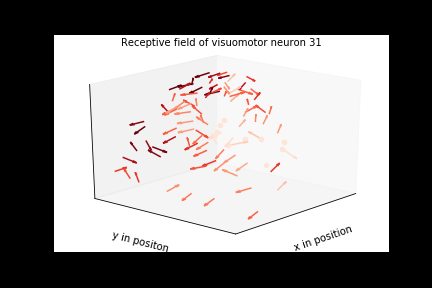

In [134]:
%matplotlib notebook
plot_max_vd(list_pos_before, list_joint_command, i)

In [12]:
def multiple_contribution(model, nb_pass):
    pos_before1 = tf.convert_to_tensor(
        np.random.random((1,5)), dtype='float32')
    pos_before2 = tf.convert_to_tensor(
        np.random.random((1,5)), dtype='float32')
    
    list_joint_cmd1 = []
    list_joint_cmd2 = []
    pos = []
    pos.append(pos_before1)
    pos.append(pos_before2)
    
    for i in tqdm.tqdm(range(32)):
        tmp_loss1 = 0
        tmp_loss2 = 0
        
        tmp_joint_command1 = zeros((1,5))
        tmp_joint_command2 = zeros((1,5))
        
        for j in range(nb_pass):
            new_joint_command1 = zeros((1,5))
            new_joint_command1[0][0] = random.choice([-1,1])*0.1
            new_joint_command1[0][1] = random.choice([-1,1])*0.1
            new_joint_command1[0][2] = random.choice([-1,1])*0.1
            new_joint_command1[0][3] = random.choice([-1,1])*0.1
            new_joint_command1[0][4] = random.choice([-1,1])*0.1
            
            new_joint_command2 = zeros((1,5))
            new_joint_command2[0][0] = random.choice([-1,1])*0.1
            new_joint_command2[0][1] = random.choice([-1,1])*0.1
            new_joint_command2[0][2] = random.choice([-1,1])*0.1
            new_joint_command2[0][3] = random.choice([-1,1])*0.1
            new_joint_command2[0][4] = random.choice([-1,1])*0.1
            
            loss1 = compute_loss_vd(model, pos_before1, new_joint_command1, i )
            loss2 = compute_loss_vd(model, pos_before2, new_joint_command2, i )
            
            if (loss1 > tmp_loss1):
                tmp_loss1 = loss1
                tmp_joint_command1 = new_joint_command1
            
            if (loss2 > tmp_loss2):
                tmp_loss2 = loss2
                tmp_joint_command2 = new_joint_command2
                
        list_joint_cmd1.append(tmp_joint_command1)
        list_joint_cmd2.append(tmp_joint_command2)
        
    return pos, list_joint_cmd1, list_joint_cmd2

def multiple_contrib(model):
    pos_before = tf.convert_to_tensor(np.random.random((1,5)),
                                      dtype = 'float32')
    
    joint_command = zeros((1,5))
    joint_command[0][0] = random.choice([-1,1])*0.1
    joint_command[0][1] = random.choice([-1,1])*0.1
    joint_command[0][2] = random.choice([-1,1])*0.1
    joint_command[0][3] = random.choice([-1,1])*0.1
    joint_command[0][4] = random.choice([-1,1])*0.1
    
    losses = []
    for i in range(32):
        tmp = compute_loss_vd(model, pos_before, joint_command, i)
        losses.append(tmp)
        
    commands = []
    
    for i in range(32):
        loss = losses[i]
        tmp_loss = 0
        j = 0
        tmp_command = zeros((1,5))
        while ((tmp_loss-loss) > 0.1) and (j<200):
            
            tmp_command[0][0] = random.choice([-1,1])*0.1
            tmp_command[0][1] = random.choice([-1,1])*0.1
            tmp_command[0][2] = random.choice([-1,1])*0.1
            tmp_command[0][3] = random.choice([-1,1])*0.1
            tmp_command[0][4] = random.choice([-1,1])*0.1
            
            tmp_loss = compute_loss_vd(model , pos_before, tmp_command, i)
            j +=1
            
        if j == 100 :
            commands.append(zeros((1,5)))
        else : 
            commands.append(tmp_command)
    
    return pos_before, losses, commands , joint_command

In [178]:
% matplotlib inline
model = encoder_conv
pos_before, losses, commands, command_initial = multiple_contrib(model)


In [181]:

def plot_multiple_contrib(pos, list_joint_cmd1, command_initial):
    fig = figure(facecolor=(0.0,0.0,0.0))
    ax = fig.gca(projection="3d")
    
    global_direction = zeros((3))
    for i in (range(32)):
        posture_before = pos
        posture_after = np.add(posture_before, list_joint_cmd1[i][0])
        
        position_after = control_robot(posture_after[0])
        position_before = control_robot(posture_before[0])
        
        tmp = position_after - position_before
        global_direction += tmp 
        plt.quiver(position_before[0],
                  position_before[1], 
                  position_before[2], 
                  tmp[0], 
                  tmp[1], 
                  tmp[2], 
                  length = 0.03, 
                  color = 'b')
        
    plt.quiver(position_before[0],
                position_before[1],
                position_before[2],
                global_direction[0], 
                global_direction[1],
                global_direction[2],
                color ='r', 
                
                length = 0.007)
    
    posture_after = np.add(posture_before, command_initial)
    position_after = control_robot(posture_after[0])
    tmp = position_after - position_before
    plt.quiver(position_before[0],
                position_before[1], 
                position_before[2], 
                tmp[0], 
                tmp[1], 
                tmp[2], 
                length = 0.05, 
                color = 'g')
    ax.set_xlabel("x in position", fontsize = 10)
    ax.set_ylabel("y in position", fontsize = 10)
    ax.set_zlabel('z in position')
    print position_before
    title = 'multiple contribution for position x = 0.55, y = 0.22, z= 0.22'
    plt.title(title, fontsize = 10)
    plt.show()



<IPython.core.display.Javascript object>


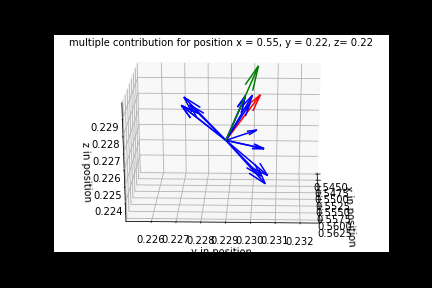

[0.55407635 0.22888773 0.2264077 ]


In [184]:
%matplotlib notebook
plot_multiple_contrib(pos_before, commands, command_initial)

### Videos


In [100]:
import matplotlib.animation as manimation

<IPython.core.display.Javascript object>


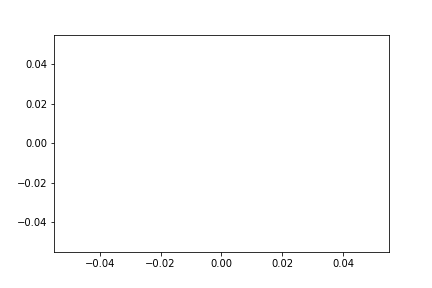

NameError: name 'xmin' is not defined

In [186]:
%matplotlib notebook
fig = plt.figure() # initialise la figure
line, = plt.plot([],[]) 
plt.xlim(xmin, xmax)
plt.ylim(-1,1)

# fonction à définir quand blit=True
# crée l'arrière de l'animation qui sera présent sur chaque image
def init():
    line.set_data([],[])
    return line,

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
 
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=False)

plt.show()


In [ ]:
def build_cornet():
    IMG_SIZE = 64
    INPUT_ENCODER_SHAPE = (IMG_SIZE, IMG_SIZE, 2)

    inputs = tf.keras.Input(shape=INPUT_ENCODER_SHAPE, name='encoder_input')

    x = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(inputs)
    x = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(x)

    y = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1])(inputs)
    y = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(y)

    #fx = tf.keras.layers.Flatten()(x)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=7, strides=(
        2, 2), activation='relu', name='conv_x_1')(x)
    fx = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fx)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(1, 1),activation='relu', name='conv_x_2')(fx)
    fx = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fx)
    
    fx = tf.keras.layers.Flatten()(fx)
    #fx = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fx1')(fx)
    fx = tf.keras.layers.Dense(LATENT_DIM, name='latent_fx2')(fx)
    fx = tf.keras.layers.Reshape((LATENT_DIM, 1,))(fx)

    #fy = tf.keras.layers.Flatten()(y)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=7, strides=(
        2, 2), activation='relu', name='conv_y_1')(y)
    fy = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fy)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(1,1), activation='relu', name='conv_y_2')(fy)
    fy = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fy)
    
    fy = tf.keras.layers.Flatten()(fy)
    #fy = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fy1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name='latent_fy2')(fy)
    fy = tf.keras.layers.Reshape((1, LATENT_DIM,))(fy)

    matmul = tf.keras.layers.Multiply()([fx, fy])

    fh = tf.keras.layers.Flatten()(matmul)
    fh = tf.keras.layers.Dense(LATENT_DIM, name='latent_fh1')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh2')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh3')(fh)

    fx = tf.keras.layers.Reshape((1, LATENT_DIM,))(fx)
    fh = tf.keras.layers.Reshape((1, LATENT_DIM,))(fh)

    outputs = tf.keras.layers.Concatenate()([fx, fh])
    encoder = tf.keras.Model(
        inputs=inputs, outputs=outputs, name='encoder_model')

    return encoder


In [ ]:
cornet = build_cornet()
cornet.summary()

In [ ]:
encoder = build_conv2D_pointwise_encoder()
encoder.summary()